This **Multiple linear regression** notebook is based on [Getting started with Neural Network for regression and Tensorflow](https://medium.com/@rajatgupta310198/getting-started-with-neural-network-for-regression-and-tensorflow-58ad3bd75223).

Some additional fixes have been applied.

In [17]:
# First import all dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import timeit
%matplotlib inline


In [18]:
df = pd.read_csv('DJI.csv') # read data set using pandas
print(df.info()) # Overview of dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
Date         1260 non-null object
Open         1260 non-null float64
High         1260 non-null float64
Low          1260 non-null float64
Close        1260 non-null float64
Adj Close    1260 non-null float64
Volume       1260 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB
None


In [19]:
df = df.drop(['Date'],axis=1) # Drop Date feature
df = df.dropna(inplace=False)  # Remove all NaN entries.
df = df.drop(['Adj Close','Volume'],axis=1) # Drop Adj Close and Volume feature
splitidx = (len(df) * 6) // 10
df_train = df[:splitidx]    # 60% training data and 40% testing data
df_test = df[splitidx:]

# Normalize train dataset and test dataset
scaler = MinMaxScaler() # For normalizing dataset

# Create and scale the train dataset, y is output and x is features (independent variables)
# Our features will be Open, High and Low (i.e. drop Close)
X_train = scaler.fit_transform(df_train.drop(['Close'],axis=1).as_matrix())
# We want to predict Close value of stock 
y_train = scaler.fit_transform(df_train['Close'].as_matrix().reshape(-1, 1))

# Create and scale the test dataset
X_test = scaler.fit_transform(df_test.drop(['Close'],axis=1).as_matrix())
y_test = scaler.fit_transform(df_test['Close'].as_matrix().reshape(-1, 1))


d:\tf-gpu\venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
d:\tf-gpu\venv\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
d:\tf-gpu\venv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
d:\tf-gpu\venv\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Below written function for denormalization of normalized data.

Parameter **df** must contain the original dataset the scaler was fitted to.
Parameter **norm_data** must contain the scaled data that has to be denormalized.

As this funtion is intended to be used with a 1D-value be sure to apply **reshape(-1,1)** to create 2D datasets as required by **fit_transform** and **inverse_transform**.

In [20]:
def denormalize(df, norm_data):
    df = df['Close'].values.reshape(-1,1)
    norm_data = norm_data.reshape(-1,1)
    scl = MinMaxScaler()
    _ = scl.fit_transform(df)
    return (scl.inverse_transform(norm_data))


**neural_net_model** is a function applying a 2 hidden layers, feed forward neural net.
Weights and biases are abbreviated as **W_1**, **W_2** and **b_1**, **b_2**.
These are variables which will be updated during training.

In [21]:
def neural_net_model(X_data,input_dim):
    # layer 1 multiplying and adding bias then activation function
    W_1 = tf.Variable(tf.random_uniform([input_dim,10]))
    b_1 = tf.Variable(tf.zeros([10]))
    layer_1 = tf.add(tf.matmul(X_data, W_1), b_1)
    layer_1 = tf.nn.relu(layer_1)

    # layer 2 multiplying and adding bias then activation function
    W_2 = tf.Variable(tf.random_uniform([10,10]))
    b_2 = tf.Variable(tf.zeros([10]))
    layer_2 = tf.add(tf.matmul(layer_1, W_2), b_2)
    layer_2 = tf.nn.relu(layer_2)
    
    # Output layer multiplying and adding bias, then activation function
    # notice output layer has one node only since we are performing regression
   
    W_O = tf.Variable(tf.random_uniform([10,1]))
    b_O = tf.Variable(tf.zeros([1]))
    output = tf.add(tf.matmul(layer_2, W_O), b_O)
    
    return output

In [22]:
xs = tf.placeholder("float")
ys = tf.placeholder("float")
output = neural_net_model(xs,3)
cost = tf.reduce_mean(tf.square(output-ys))
# our mean squared error cost function
train = tf.train.GradientDescentOptimizer(0.001).minimize(cost)
# Gradient Descent optimiztion just discussed above for updating weights and biases

In [23]:
def main():
    cost_t = []
    global y_test

    '''
    Create a ConfigProto that uses a maximum of six threads for single operations and a 
    maximum of eight threads for parallel operations. 
    Then use the ConfigPrototo to create a session.
    '''
#     conf = tf.ConfigProto(intra_op_parallelism_threads=6,
#     inter_op_parallelism_threads=8,
#     log_device_placement=True)

    conf = tf.ConfigProto(log_device_placement=True)

    with tf.Session(config=conf) as sess:
        # Initiate session and initialize all vaiables
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        #saver.restore(sess,'./DJI.ckpt')
        for i in range(100):
            for j in range(X_train.shape[0]):
                # Run cost and train with each sample
                sess.run([cost,train],feed_dict={xs:X_train[j,:].reshape(1,3), ys:y_train[j]})

            # Calculate cost for both train and test dataset
            cost_t.append(sess.run(cost, feed_dict={xs:X_train, ys:y_train}))
            print('Epoch :',i,'Cost :',cost_t[i])

        # predict output of test data after training
        pred = sess.run(output, feed_dict={xs:X_test})

        #Denormalize data     
        y_test = denormalize(df_test,y_test)
        pred = denormalize(df_test,pred)

        # Generate plot of original vs predicted data
        plt.plot(range(y_test.shape[0]), y_test, label="Original Data")
        plt.plot(range(y_test.shape[0]), pred, label="Predicted Data")
        plt.legend(loc='best')
        plt.ylabel('Stock Value')
        plt.xlabel('Days')
        plt.title('Stock Market Dow Jones Index')
        plt.show()
        # Save model if so desired
        #if input('Save model ? [Y/N]') == 'Y':
        # Be sure to provide the current directory as part of filename, otherwise you get an error
        saver.save(sess,'./DJI.ckpt')
        print('Model Saved')

Epoch : 0 Cost : 0.2551496
Epoch : 1 Cost : 0.066406555
Epoch : 2 Cost : 0.029974526
Epoch : 3 Cost : 0.016591005
Epoch : 4 Cost : 0.010985422
Epoch : 5 Cost : 0.008314732
Epoch : 6 Cost : 0.0067762737
Epoch : 7 Cost : 0.005748969
Epoch : 8 Cost : 0.004943074
Epoch : 9 Cost : 0.004281331
Epoch : 10 Cost : 0.0037276
Epoch : 11 Cost : 0.0032842495
Epoch : 12 Cost : 0.0029353413
Epoch : 13 Cost : 0.002659625
Epoch : 14 Cost : 0.0024270383
Epoch : 15 Cost : 0.0022310643
Epoch : 16 Cost : 0.0020676227
Epoch : 17 Cost : 0.0019284072
Epoch : 18 Cost : 0.0018103876
Epoch : 19 Cost : 0.001709374
Epoch : 20 Cost : 0.0016168442
Epoch : 21 Cost : 0.0015334144
Epoch : 22 Cost : 0.0014591003
Epoch : 23 Cost : 0.0013900051
Epoch : 24 Cost : 0.0013261581
Epoch : 25 Cost : 0.0012659851
Epoch : 26 Cost : 0.0012087747
Epoch : 27 Cost : 0.0011583397
Epoch : 28 Cost : 0.001111336
Epoch : 29 Cost : 0.0010712654
Epoch : 30 Cost : 0.001035766
Epoch : 31 Cost : 0.0010019894
Epoch : 32 Cost : 0.00097364635
Epoc

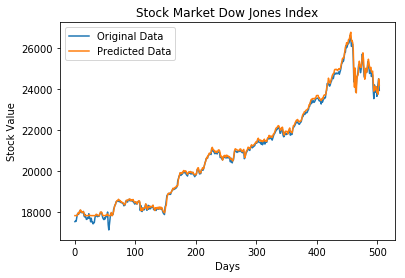

Model Saved


75.3912333852814

In [24]:
timeit.timeit(main, number=1)